10000


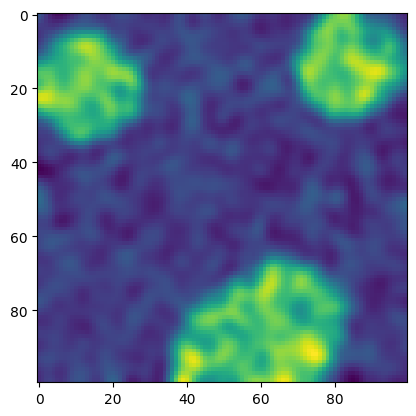

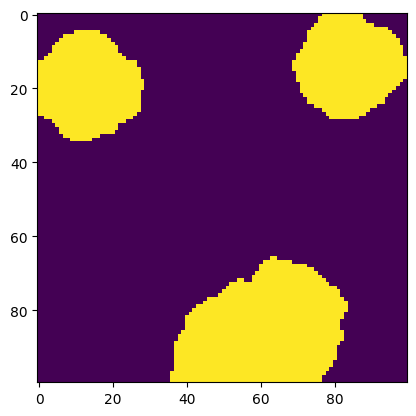

In [120]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from skimage.data import binary_blobs
import skimage.measure
import bfio
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu

DATA_DIR = Path("tmp")

img_dim = (100, 100)
assert img_dim[0] == img_dim[1]
img_size = np.prod(img_dim)

print(img_size)

template = np.random.rand(*img_dim)

def generate_blobs(size: int):
    mask = binary_blobs(
            n_dim= 2,
            length=size,
            blob_size_fraction=0.5,
            volume_fraction=0.25,
            rng=10
        )
    return mask

def save_2D_image(img, out_path):
    with bfio.BioWriter(out_path) as writer:
        (y, x) = img.shape
        writer.Y = y
        writer.X = x
        writer.dtype = img.dtype
        writer[:] = img[:]

mask = generate_blobs(img_dim[0])
blobs_1, num_features_1 = ndi.label(mask)
blobs_2, num_features_2 = skimage.measure.label(mask, return_num=True)

assert np.array_equal(blobs_1,blobs_2)
assert np.array_equal(num_features_1,num_features_2)

img = template  + template * mask
img = ndi.gaussian_filter(img, sigma=2)
plt.imshow(img)
plt.show()

save_2D_image(img, DATA_DIR / "test_image.tif")

def test_label(img):
    rois, num_rois = ndi.label(img)
    assert (num_rois == num_features_1), f"{num_rois}, expect: {num_features_1}"

threshold = threshold_otsu(img)


img = img > threshold

plt.imshow(img)
plt.show()

test_label(img)

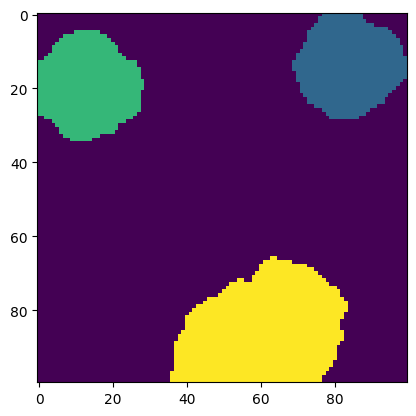

 84, 14, 31
 14, 20, 30
 60, 83, 48


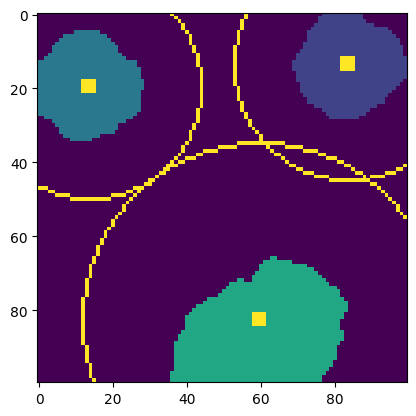

In [125]:
from scipy import ndimage

def draw_regions(img, cx,cy,radius):
    img[cy-2:cy+2, cx-2:cx+2] = 5
    circle = skimage.draw.circle_perimeter(cy,cx, radius, shape=labeled_image.shape)
    img[circle] = 5


labeled_image, num_rois = ndi.label(img)
assert num_rois == 3

plt.imshow(labeled_image)
plt.show()

rois = ndimage.find_objects(labeled_image)
assert len(rois) == num_rois

cxs = []
cys = []
radii = []

for roi in rois:
    length_y = (roi[0].stop - roi[0].start)
    length_x = (roi[1].stop - roi[1].start)
    cy = roi[0].start + length_y // 2
    cx = roi[1].start + length_x // 2
    radius = max(length_x,length_y)
    cxs.append(cx), cys.append(cy), radii.append(radius)

    print(f" {cx}, {cy}, {radius}")
    
    draw_regions(labeled_image, cx, cy, radius)

plt.imshow(labeled_image)
plt.show()

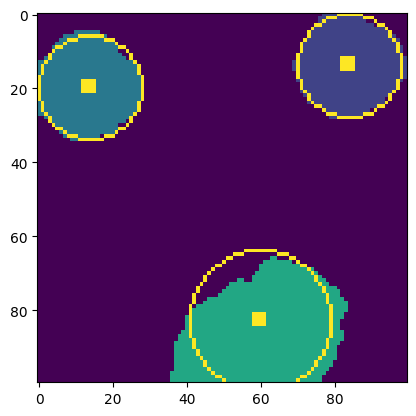

In [123]:
""""For roundish blob, the radius estimation gets definitely a tighter bound."""

def get_wells(image: np.ndarray) -> tuple[list[float], list[float], list[float], int]:

    markers, n_objects = ndi.label(image)

    radii = []
    cx = []
    cy = []
    for s in ndi.find_objects(markers):
        cy.append((s[0].start + s[0].stop) / 2)
        cx.append((s[1].start + s[1].stop) / 2)
        radii.append(np.sqrt((markers[s] > 0).sum() / np.pi))

    return markers, (cx, cy, radii, n_objects)


markers, circles = get_wells(img)
for cx,cy,radius in zip(circles[0], circles[1],circles[2]):
    draw_regions(markers, int(cx),int(cy),int(radius))

plt.imshow(markers)

In [140]:
print(cxs, cys, radii)
cx = cxs
cy = cys

# rearrange coordinates so we can apply the rotation
locations = np.vstack([cx, cy]).T
print(locations)
print(locations.shape)

# let's only consider a few rotations.
print("angle: ", np.arange(0, np.pi, np.pi / 4))
print("angle in degrees: ", np.arange(0, 180, 180 / 4))

ROTATION = np.vstack(
    [
        -np.sin(np.arange(0, np.pi, np.pi / 4)),
        np.cos(np.arange(0, np.pi, np.pi / 4)),
    ]
)
# cy coordinates after clockwise rotation
transform = locations @ ROTATION

# we can verify that is looks good for 90degree rotation
print(transform)

print(transform.shape)



[84, 14, 60] [14, 20, 83] [31, 30, 48]
[[84 14]
 [14 20]
 [60 83]]
(3, 2)
angle:  [0.         0.78539816 1.57079633 2.35619449]
angle in degrees:  [  0.  45.  90. 135.]
[[  14.          -49.49747468  -84.          -69.29646456]
 [  20.            4.24264069  -14.          -24.04163056]
 [  83.           16.26345597  -60.         -101.11626971]]
(3, 4)


In [150]:
transform.max(axis=0)
transform.min(axis=0)

# projection y of every point
transform.max(axis=0) - transform.min(axis=0)


angle = np.argmax(transform.max(axis=0) - transform.min(axis=0))

# 
print(transform.max(axis=0))
print(transform.min(axis=0))
print(np.arange(0, 180, 180 / 4)[angle])

[ 83.          16.26345597 -14.         -24.04163056]
[  14.          -49.49747468  -84.         -101.11626971]
135.0
